In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)
input_steps = 3  
output_steps = 6   


In [2]:
data_file = "data_readed.xlsx"
df = pd.read_excel(data_file)
print("DataFrame head:")
print(df.head())

# Xác định 10 features làm đầu vào (giả sử nằm ở cột thứ 4 đến 13)
features = df.columns[3:13].tolist()  
target_label = 'AWS'

# Chuyển đổi cột datetime và thêm các cột tuần, tháng, năm
df['datetime'] = pd.to_datetime(df['datetime'])
df['week'] = df['datetime'].dt.isocalendar().week
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df = df.sort_values(by='datetime').reset_index(drop=True)
time_features = ['week', 'month', 'year']
features += time_features
df[features] = df[features].fillna(method='ffill')
for col in features:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)
df[features] = df[features].astype(np.float32)


DataFrame head:
   row  col            datetime  AWS    CAPE          CIN        EWSS  \
0    0  104 2020-10-01 00:00:00  0.0  197.25    61.953484 -113.054688   
1    0  104 2020-10-01 01:00:00  0.0  138.50  9999.000000 -128.285156   
2    0  104 2020-10-01 02:00:00  0.0  102.00  9999.000000 -120.671875   
3    0  104 2020-10-01 03:00:00  0.0  160.75  9999.000000 -169.191406   
4    0  104 2020-10-01 04:00:00  0.0  204.50   213.468903 -304.347656   

         IE      ISOR         KX  ...    SLHF      SLOR    SSHF      TCLW  \
0 -0.000017  0.676296  36.621414  ...  -59037  0.023543  -27549  0.373413   
1 -0.000038  0.676296  36.078514  ... -203202  0.023543  -64968  0.274780   
2 -0.000055  0.676296  35.410492  ... -376145  0.023543  -81566  0.194763   
3 -0.000064  0.676296  34.843140  ... -609080  0.023543 -101141  0.187439   
4 -0.000112  0.676296  34.893394  ... -654851  0.023543  -97831  0.104156   

         TCW       TCWV      U250      U850      V250      V850  
0  59.393524  59

C:\Users\giakh\AppData\Local\Temp\ipykernel_14100\3713090108.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features] = df[features].fillna(method='ffill')


In [3]:
def create_dataset(df, features, target_label, past=6, future=6):
    X, y = [], []
    feature_values = df[features].values
    target_values = df[target_label].values
    for i in range(len(df) - past - future + 1):
        X.append(feature_values[i:(i+past)])
        y.append(target_values[i+past:i+past+future])
    return np.array(X), np.array(y)

X, y = create_dataset(df, features, target_label, input_steps, output_steps)
print("Dataset shape:", X.shape, y.shape)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Dataset shape: (657673, 3, 13) (657673, 6)


In [4]:
def create_model(input_shape, output_steps):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=input_shape))
    model.add(Dense(output_steps))
    model.compile(optimizer='adam', loss='mse')
    return model
sample_model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_steps=output_steps)
sample_model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,358 (79.52 KB)

 Trainable params: 20,358 (79.52 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_mse = []
cv_r2 = []
fold = 1

for train_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    model_cv = create_model(input_shape=(X_tr.shape[1], X_tr.shape[2]), output_steps=output_steps)
    history_cv = model_cv.fit(X_tr, y_tr.astype(np.float32), epochs=50, batch_size=32,
                          validation_data=(X_val, y_val.astype(np.float32)), verbose=0)

    
    # Dự đoán và tính các chỉ số trên tập validation của fold này
    y_val_pred = model_cv.predict(X_val)
    mse_fold = mean_squared_error(y_val.flatten(), y_val_pred.flatten())
    r2_fold = r2_score(y_val.flatten(), y_val_pred.flatten())
    cv_mse.append(mse_fold)
    cv_r2.append(r2_fold)
    
    print(f"Fold {fold}: MSE = {mse_fold:.4f}, R2 = {r2_fold:.4f}")
    fold += 1

print("CV Average MSE:", np.mean(cv_mse))
print("CV Average R2:", np.mean(cv_r2))


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 1: MSE = 0.0007, R2 = -2.3831


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Fold 2: MSE = 0.0003, R2 = -0.1427


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Fold 3: MSE = 0.0001, R2 = -0.1194


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 4: MSE = 0.0001, R2 = -0.0006


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2741/2741 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 5: MSE = 0.0002, R2 = -0.0162
CV Average MSE: 0.00030842189444229006
CV Average R2: -0.5324170589447021


In [6]:
final_model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_steps=output_steps)
history = final_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
final_model.save('rain_prediction_model_v2.h5')


Epoch 1/100


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6577/6577 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 3.8767e-04 - val_loss: 2.1904e-04
Epoch 2/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 2.0260e-04 - val_loss: 2.1240e-04
Epoch 3/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9953e-04 - val_loss: 2.0969e-04
Epoch 4/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9865e-04 - val_loss: 2.0932e-04
Epoch 5/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9824e-04 - val_loss: 2.0910e-04
Epoch 6/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9803e-04 - val_loss: 2.0894e-04
Epoch 7/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9791e-04 - val_loss: 2.0881e-04
Epoch 8/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9781e-04 - val_loss: 2.0868e-04
Epoch 9/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9773e-04 - val_loss: 2.0852e-04
Epoch 10/100
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.9766e-04 - val_loss: 2.0834e-04
Epoch 11/100
6577/6577 ━━━━━━━━

4111/4111 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Test MSE: 0.0009664162062108517
Test MAE: 0.010519864968955517
Test R2: -0.0962446928024292


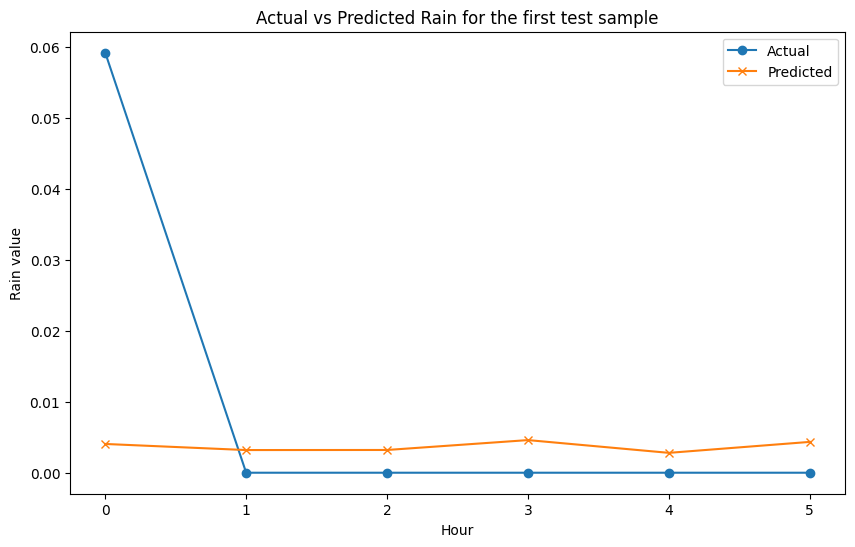

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = final_model.predict(X_test)
mse_test = mean_squared_error(y_test.flatten(), y_pred.flatten())
mae_test = mean_absolute_error(y_test.flatten(), y_pred.flatten())
r2_test = r2_score(y_test.flatten(), y_pred.flatten())

print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R2:", r2_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred[0], marker='x', label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample')
plt.legend()
plt.show()


XGB Test MSE: 0.0009322514524683356
XGB Test MAE: 0.010153519921004772
XGB Test R2: -0.05749022960662842


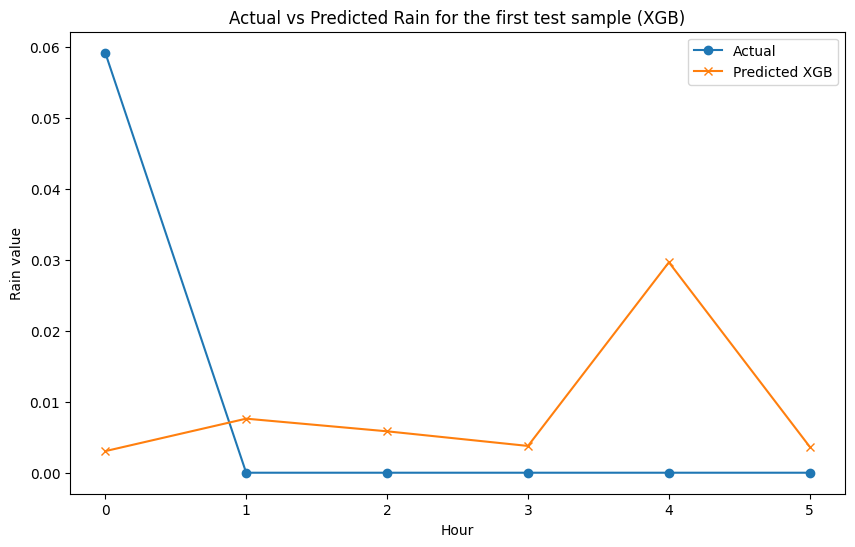

In [8]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten X_train và X_test từ (samples, input_steps, features) sang (samples, input_steps*features)
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Khởi tạo mô hình XGB cho bài toán multi-output
xgb_reg = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
xgb_reg.fit(X_train_xgb, y_train)

# Dự đoán trên tập test với XGB
y_pred_xgb = xgb_reg.predict(X_test_xgb)

mse_xgb = mean_squared_error(y_test.flatten(), y_pred_xgb.flatten())
mae_xgb = mean_absolute_error(y_test.flatten(), y_pred_xgb.flatten())
r2_xgb = r2_score(y_test.flatten(), y_pred_xgb.flatten())

print("XGB Test MSE:", mse_xgb)
print("XGB Test MAE:", mae_xgb)
print("XGB Test R2:", r2_xgb)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred_xgb[0], marker='x', label='Predicted XGB')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample (XGB)')
plt.legend()
plt.show()


Ensemble Test MSE: 0.0009166955132968724
Ensemble Test MAE: 0.009390398859977722
Ensemble Test R2: -0.039844512939453125


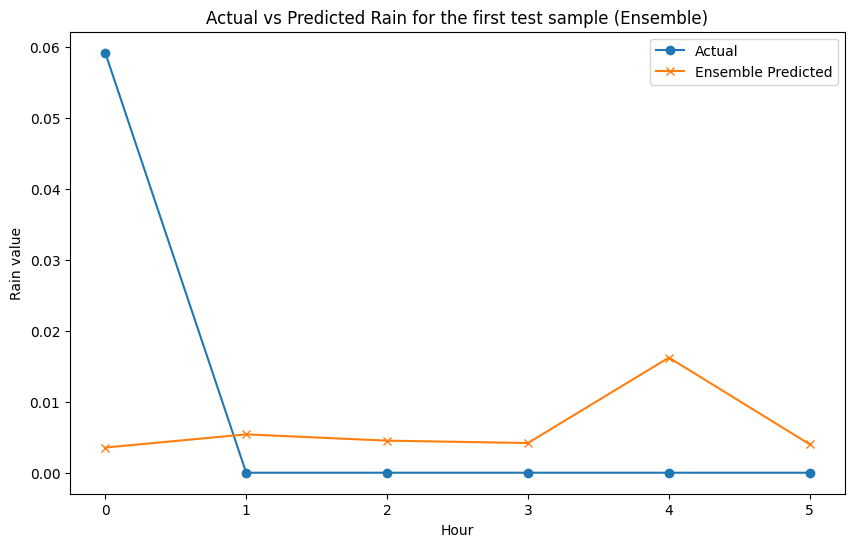

In [9]:
# Giả sử y_pred là dự đoán từ LSTM và y_pred_xgb là dự đoán từ XGB đã có
y_pred_ensemble = (y_pred + y_pred_xgb) / 2

# Tính các chỉ số cho dự đoán kết hợp
mse_ensemble = mean_squared_error(y_test.flatten(), y_pred_ensemble.flatten())
mae_ensemble = mean_absolute_error(y_test.flatten(), y_pred_ensemble.flatten())
r2_ensemble = r2_score(y_test.flatten(), y_pred_ensemble.flatten())

print("Ensemble Test MSE:", mse_ensemble)
print("Ensemble Test MAE:", mae_ensemble)
print("Ensemble Test R2:", r2_ensemble)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0], marker='o', label='Actual')
plt.plot(y_pred_ensemble[0], marker='x', label='Ensemble Predicted')
plt.xlabel('Hour')
plt.ylabel('Rain value')
plt.title('Actual vs Predicted Rain for the first test sample (Ensemble)')
plt.legend()
plt.show()


In [10]:
%pip install tqdm rioxarray

import os
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from pathlib import Path
import rioxarray

HEIGHT, WIDTH = 90, 250
INPUT_STEPS = 6
OUTPUT_STEPS = 6

def get_timestamp_list(start, end, step_hours=1):
    return [start + timedelta(hours=i) for i in range(0, int((end - start).total_seconds() // 3600) + 1, step_hours)]

def read_radar_image(timestamp):
    file_path = f"DATA_SV/Precipitation/AWS/{timestamp.year}/{timestamp.month:02}/{timestamp.day:02}/AWS_{timestamp.strftime('%Y%m%d%H%M%S')}.tif"
    path = Path(file_path)
    if not path.exists():
        return None
    try:
        dataset = rioxarray.open_rasterio(file_path)
        data = dataset[0].values.astype(np.float32)
        data[np.isinf(data)] = np.nan
        return np.nan_to_num(data, nan=0.0)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def build_dataset(start_time, end_time, input_steps=6, output_steps=6):
    X, y = [], []
    timestamps = get_timestamp_list(start_time, end_time)
    for i in tqdm(range(len(timestamps) - input_steps - output_steps + 1)):
        input_seq = []
        output_seq = []
        valid = True
        for j in range(input_steps):
            img = read_radar_image(timestamps[i + j])
            if img is None:
                valid = False
                break
            input_seq.append(img)

        for j in range(output_steps):
            img = read_radar_image(timestamps[i + input_steps + j])
            if img is None:
                valid = False
                break
            output_seq.append(img)

        if valid:
            X.append(np.expand_dims(input_seq, axis=-1))   # shape: (6, 90, 250, 1)
            y.append(np.expand_dims(output_seq, axis=-1))  # shape: (6, 90, 250, 1)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Load dữ liệu từ tháng 10/2020
start_time = datetime(2020, 10, 1, 0)
end_time = datetime(2020, 10, 31, 23)

X_radar, y_radar = build_dataset(start_time, end_time)
print("Radar Dataset shapes:", X_radar.shape, y_radar.shape)


Note: you may need to restart the kernel to use updated packages.


100%|██████████| 733/733 [01:05<00:00, 11.21it/s]


Radar Dataset shapes: (720, 6, 90, 250, 1) (720, 6, 90, 250, 1)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D

def build_convlstm_model(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=True, activation='tanh'))
    model.add(BatchNormalization())

    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         padding='same', return_sequences=True, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
                     activation='relu', padding='same'))

    model.compile(optimizer='adam', loss='mse')
    return model

model = build_convlstm_model(input_shape=(INPUT_STEPS, HEIGHT, WIDTH, 1))
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 6, 90, 250, 32) │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 90, 250, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 6, 90, 250, 32) │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 90, 250, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 6, 90, 250, 1)  │           865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,121 (441.88 KB)

 Trainable params: 112,993 (441.38 KB)

 Non-trainable params: 128 (512.00 B)

In [12]:
from sklearn.model_selection import train_test_split

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_radar, y_radar, test_size=0.2, random_state=42)

history = model.fit(X_train_r, y_train_r, epochs=20, batch_size=64,
                    validation_data=(X_val_r, y_val_r))


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 595s 65s/step - loss: 0.2832 - val_loss: 0.1426
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 628s 70s/step - loss: 0.1247 - val_loss: 0.1426
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 601s 68s/step - loss: 0.1130 - val_loss: 0.1425
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 591s 64s/step - loss: 0.1101 - val_loss: 0.1425
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 557s 61s/step - loss: 0.1067 - val_loss: 0.1423
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 587s 64s/step - loss: 0.1029 - val_loss: 0.1422
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 604s 67s/step - loss: 0.1002 - val_loss: 0.1421
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 574s 64s/step - loss: 0.0988 - val_loss: 0.1421
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 638s 72s/step - loss: 0.0978 - val_loss: 0.1420
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 566s 62s/step - loss: 0.0971 - val_loss: 0.1420
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 587s 64s/step - loss: 0.0963 - val_loss: 0.1419
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 603s 68s/step - loss: 0.0955 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


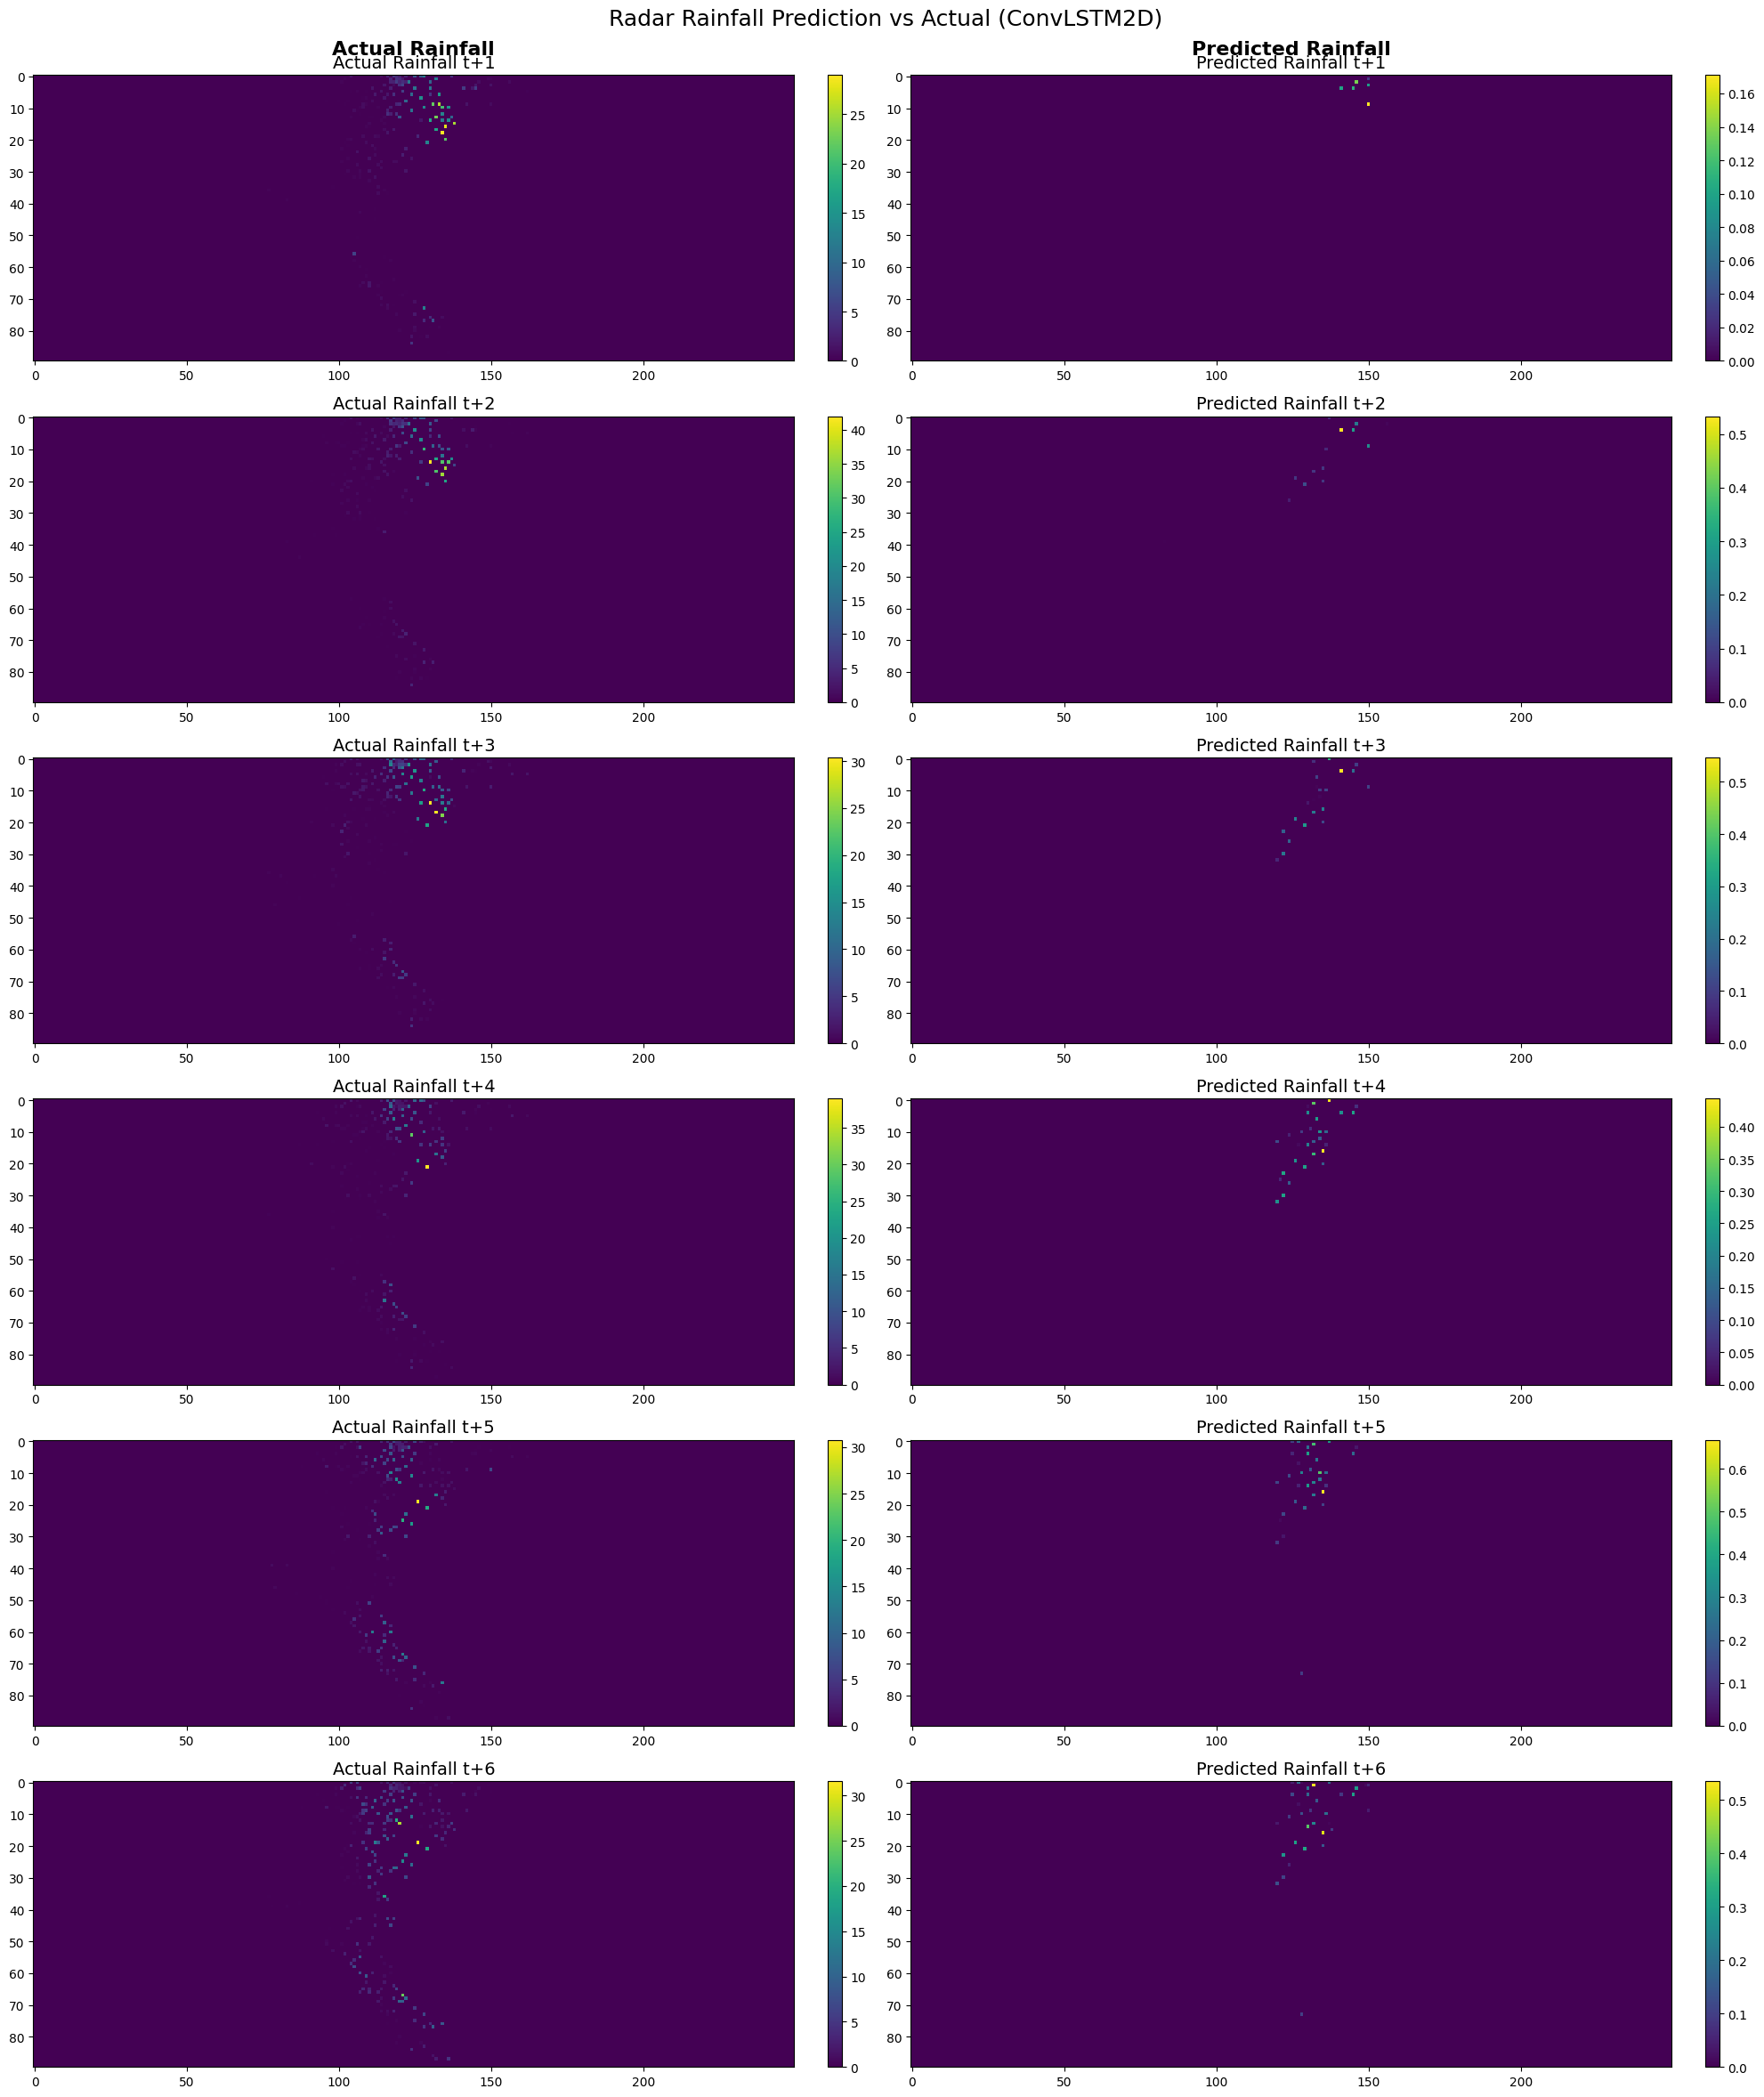

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Tham số vẽ
sample_index = 0  # Chọn sample để hiển thị
actual_maps = y_val_r[sample_index]  # shape: (6, 90, 250, 1)
predicted_maps = model.predict(X_val_r[[sample_index]])[0]  # shape: (6, 90, 250, 1)

# Tạo colormap với NaN hiển thị màu trắng
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

fig, axes = plt.subplots(nrows=OUTPUT_STEPS, ncols=2, figsize=(20, OUTPUT_STEPS * 4))

for i in range(OUTPUT_STEPS):
    # Bản đồ thực tế
    ax_actual = axes[i, 0]
    data_actual = actual_maps[i, :, :, 0]
    im_actual = ax_actual.imshow(data_actual, cmap=cmap, aspect='auto')
    ax_actual.set_title(f"Actual Rainfall t+{i+1}", fontsize=14)
    fig.colorbar(im_actual, ax=ax_actual, fraction=0.046, pad=0.04)

    # Bản đồ dự đoán
    ax_pred = axes[i, 1]
    data_pred = predicted_maps[i, :, :, 0]
    im_pred = ax_pred.imshow(data_pred, cmap=cmap, aspect='auto')
    ax_pred.set_title(f"Predicted Rainfall t+{i+1}", fontsize=14)
    fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

# Ghi chú tiêu đề cột
for ax, label in zip(axes[0], ["Actual Rainfall", "Predicted Rainfall"]):
    ax.annotate(label, xy=(0.5, 1.05), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Radar Rainfall Prediction vs Actual (ConvLSTM2D)", fontsize=18)
plt.show()
